In [11]:
# Module Import
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import json
from IPython.display import display
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    GRU, LSTM, Bidirectional,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    LayerNormalization, MultiHeadAttention, Add
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tcn import TCN
from sklearn.manifold import TSNE

In [12]:
# 데이터 전처리
df = pd.read_csv('../frontend/public/sensor.csv')

df.interpolate(method='linear', inplace=True)
df = df.drop(columns=['sensor_15'])
sensor_cols = [col for col in df.columns if col.startswith("sensor_")]
df_sensors = df[sensor_cols]

sensor_stds = df_sensors.std()
low_std_cols = sensor_stds[sensor_stds < 1.2].index.tolist()
df= df.drop(columns=low_std_cols)
num_cols = df.select_dtypes(include='number').columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.columns

C:\Users\LEETJ\AppData\Local\Temp\ipykernel_18852\1866072286.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


Index(['Unnamed: 0', 'timestamp', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51', 'machine_status'],
      dtype='object')

In [13]:
# 고장 유형 분류 window 생성
def extract_pre_failure_windows(broken_times, df, window=10):
    segments = []
    used_broken_times = []

    for i, t in enumerate(broken_times):
        temp_normal = df[df['timestamp'] < t].tail(window)

        temp_broken = df[df['timestamp'] == t]

        if len(temp_normal) == window and len(temp_broken) == 1 and 'BROKEN' not in temp_normal['machine_status'].values:
            combined = pd.concat([temp_normal, temp_broken])
            combined = combined.copy()
            combined['label'] = '1'
            combined['case_id'] = f"case_{i}"
            segments.append(combined)
            used_broken_times.append(t)

    return pd.concat(segments).reset_index(drop=True), used_broken_times

In [14]:
# 데이터 분할 학습(60%-5건), 검증(40%-2건)
broken_times = df[df['machine_status'] == 'BROKEN']['timestamp'].drop_duplicates().sort_values().reset_index(drop=True)
df_pre_failure_all, used_broken_times = extract_pre_failure_windows(broken_times, df)


train_cases = [f"case_{i}" for i in range(5)]       #60%
test_cases = [f"case_{i}" for i in range(5, 7)]     #40%

df_train = df_pre_failure_all[df_pre_failure_all['case_id'].isin(train_cases)].copy()
df_test = df_pre_failure_all[df_pre_failure_all['case_id'].isin(test_cases)].copy()

print(len(train_cases))
print(len(test_cases))
print(len(df_train))
print(len(df_test))
display(df_train['case_id'].value_counts())
display(df_test['case_id'].value_counts())

5
2
55
22


case_id
case_0    11
case_1    11
case_2    11
case_3    11
case_4    11
Name: count, dtype: int64

case_id
case_5    11
case_6    11
Name: count, dtype: int64

In [15]:
# 클러스터링 수행
sensor_cols = [col for col in df_train.columns if 'sensor' in col]

X_train = df_train[sensor_cols]
X_test = df_test[sensor_cols]

# KMeans
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters=2, random_state=42)
kmeans2.fit(X_train)
df_train['kmeans_cluster2'] = kmeans2.labels_

kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans3.fit(X_train)
df_train['kmeans_cluster3'] = kmeans3.labels_

kmeans4= KMeans(n_clusters=4, random_state=42)
kmeans4.fit(X_train)
df_train['kmeans_cluster4'] = kmeans4.labels_

# GMM
from sklearn.mixture import GaussianMixture

gmm2 = GaussianMixture(n_components=2, random_state=42)
gmm2.fit(X_train)
df_train['gmm_cluster2'] = gmm2.predict(X_train)

gmm3 = GaussianMixture(n_components=3, random_state=42)
gmm3.fit(X_train)
df_train['gmm_cluster3'] = gmm3.predict(X_train)

gmm4 = GaussianMixture(n_components=4, random_state=42)
gmm4.fit(X_train)
df_train['gmm_cluster4'] = gmm4.predict(X_train)

In [16]:
# 모델 평가
from sklearn.metrics import silhouette_score, davies_bouldin_score

kmeans2_silhouette = silhouette_score(X_train, df_train['kmeans_cluster2'])
kmeans2_dbi = davies_bouldin_score(X_train, df_train['kmeans_cluster2'])

kmeans3_silhouette = silhouette_score(X_train, df_train['kmeans_cluster3'])
kmeans3_dbi = davies_bouldin_score(X_train, df_train['kmeans_cluster3'])

kmeans4_silhouette = silhouette_score(X_train, df_train['kmeans_cluster4'])
kmeans4_dbi = davies_bouldin_score(X_train, df_train['kmeans_cluster4'])

gmm2_silhouette = silhouette_score(X_train, df_train['gmm_cluster2'])
gmm2_dbi = davies_bouldin_score(X_train, df_train['gmm_cluster2'])

gmm3_silhouette = silhouette_score(X_train, df_train['gmm_cluster3'])
gmm3_dbi = davies_bouldin_score(X_train, df_train['gmm_cluster3'])

gmm4_silhouette = silhouette_score(X_train, df_train['gmm_cluster4'])
gmm4_dbi = davies_bouldin_score(X_train, df_train['gmm_cluster4'])

print(f"[KMeans2] Silhouette: {kmeans2_silhouette:.4f}, DBI: {kmeans2_dbi:.4f}")
print(f"[GMM2]    Silhouette: {gmm2_silhouette:.4f}, DBI: {gmm2_dbi:.4f}")

print(f"[KMeans3] Silhouette: {kmeans3_silhouette:.4f}, DBI: {kmeans3_dbi:.4f}")
print(f"[GMM3]    Silhouette: {gmm3_silhouette:.4f}, DBI: {gmm3_dbi:.4f}")


print(f"[KMeans4] Silhouette: {kmeans4_silhouette:.4f}, DBI: {kmeans4_dbi:.4f}")
print(f"[GMM4]    Silhouette: {gmm4_silhouette:.4f}, DBI: {gmm4_dbi:.4f}")

[KMeans2] Silhouette: 0.8547, DBI: 0.1947
[GMM2]    Silhouette: 0.8547, DBI: 0.1947
[KMeans3] Silhouette: 0.4275, DBI: 0.7465
[GMM3]    Silhouette: 0.4275, DBI: 0.7465
[KMeans4] Silhouette: 0.7340, DBI: 0.3855
[GMM4]    Silhouette: 0.7340, DBI: 0.3855


,case_id,kmeans_cluster3,is_new_cluster,is_new_cluster_highpercent,timestamp
0,case_5,0,True,73%,2018-07-08 00:11:00
1,case_6,2,False,0%,2018-07-25 14:00:00


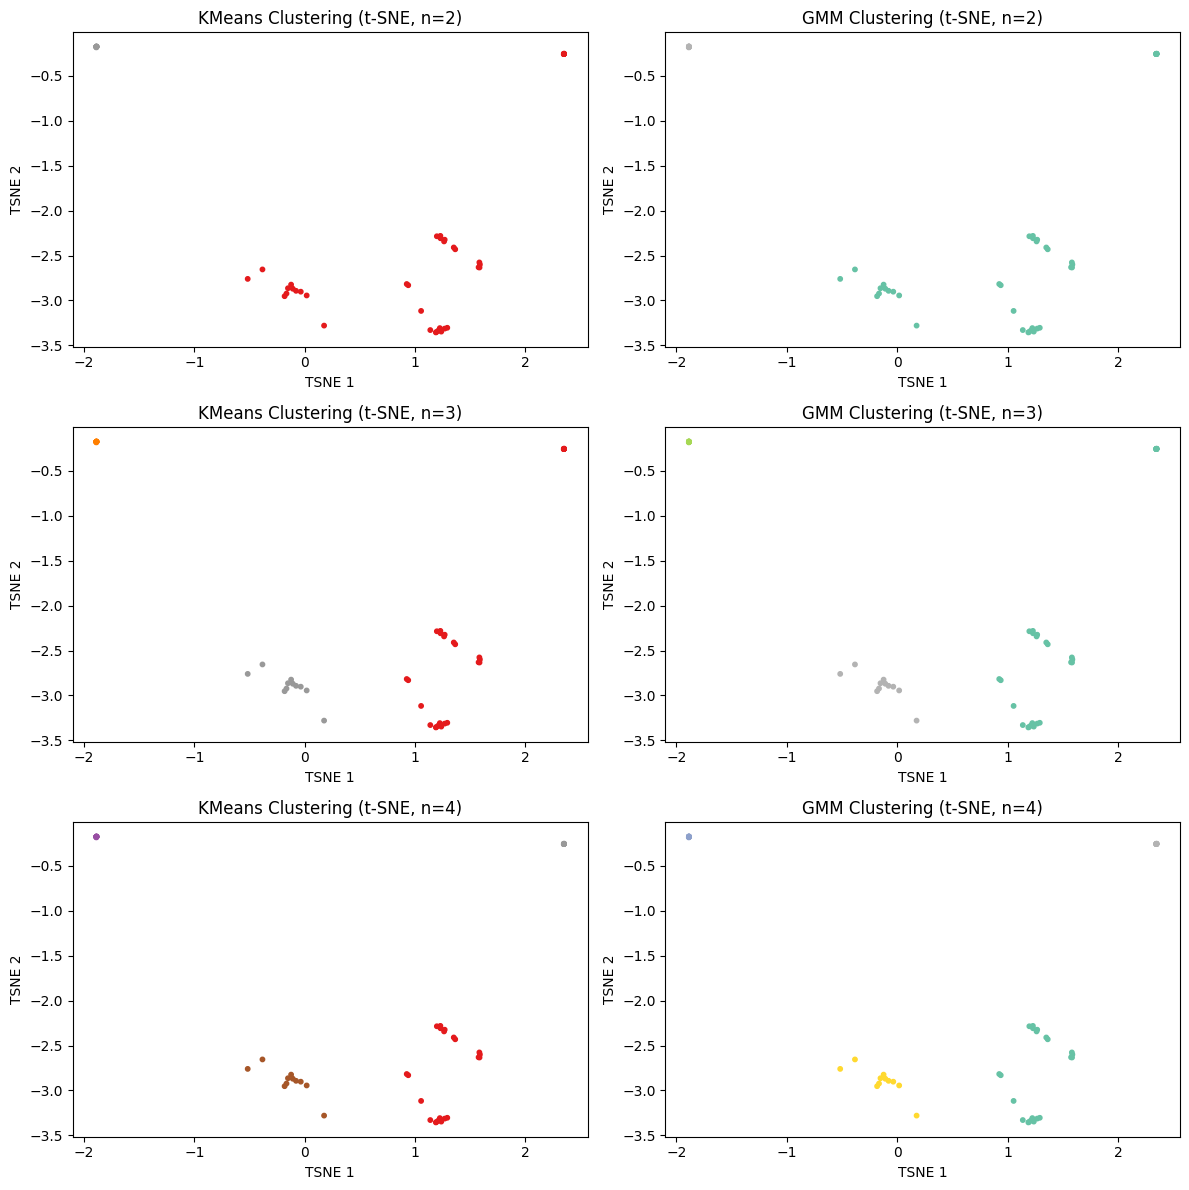

In [17]:
# Summay
df_test['kmeans_cluster3'] = kmeans3.predict(X_test)
train_distances = kmeans3.transform(X_train)
threshold = train_distances.min(axis=1).max()
test_distances = kmeans3.transform(X_test)
df_test['is_new_cluster'] = test_distances.min(axis=1) > threshold

latest_timestamps = df_test.groupby('case_id')['timestamp'].max().reset_index()

summary = (
    df_test.groupby('case_id')
    .agg(
        total=('is_new_cluster', 'size'),
        true_count=('is_new_cluster', 'sum'),
        cluster_mode=('kmeans_cluster3', lambda x: x.mode()[0] if not x.mode().empty else -1)
    )
    .reset_index()
)

summary['false_count'] = summary['total'] - summary['true_count']
summary['is_new_cluster'] = summary['true_count'] >= summary['false_count']
summary['is_new_cluster_highpercent'] = summary.apply(
    lambda row: f"{row['true_count'] / row['total'] * 100:.0f}%", axis=1
)

summary = summary.merge(latest_timestamps, on='case_id')
summary = summary[['case_id', 'cluster_mode', 'is_new_cluster', 'is_new_cluster_highpercent', 'timestamp']]
summary.columns = ['case_id', 'kmeans_cluster3', 'is_new_cluster', 'is_new_cluster_highpercent', 'timestamp']

display(summary)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_train)

cluster_nums = [2, 3, 4]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for i, n in enumerate(cluster_nums):
    axes[i, 0].scatter(X_2d[:, 0], X_2d[:, 1], c=df_train[f'kmeans_cluster{n}'], cmap='Set1', s=10)
    axes[i, 0].set_title(f"KMeans Clustering (t-SNE, n={n})")
    axes[i, 0].set_xlabel("TSNE 1"); axes[i, 0].set_ylabel("TSNE 2")
    axes[i, 1].scatter(X_2d[:, 0], X_2d[:, 1], c=df_train[f'gmm_cluster{n}'], cmap='Set2', s=10)
    axes[i, 1].set_title(f"GMM Clustering (t-SNE, n={n})")
    axes[i, 1].set_xlabel("TSNE 1"); axes[i, 1].set_ylabel("TSNE 2")

plt.tight_layout()
plt.show()